In [1]:
# import all necessary modules
import json
import seaborn as sns
import datalab.storage as storage
import datalab.bigquery as bq
import pandas as pd
import numpy as np
import urllib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image as img
import glob
from IPython.display import Image, display
%matplotlib inline

To view all full columns of any dataframe, not truncated, we set the option below:

In [2]:
pd.set_option('display.max_colwidth', -1)

### Importing Recipe Data
Recipes are stored on Google Cloud Storage (GCS) as JSON objects. These recipes can be found within the kadaif.getwellio.com bucket. For example here we are listing a few of these JSON recipe files

In [2]:
%sh
gsutil ls gs://kadaif.getwellio.com/kadaif/datasets/recipes/individual/0/0/0000*

gs://kadaif.getwellio.com/kadaif/datasets/recipes/individual/0/0/00002a86de1183ea2355f0cd778dabdd.json
gs://kadaif.getwellio.com/kadaif/datasets/recipes/individual/0/0/00003e83d608250bef61c4ca9e11fc90.json
gs://kadaif.getwellio.com/kadaif/datasets/recipes/individual/0/0/00006c02a0b3374ece36e764ccf71160.json
gs://kadaif.getwellio.com/kadaif/datasets/recipes/individual/0/0/00006cd1c97656127b813b1f60afd642.json
gs://kadaif.getwellio.com/kadaif/datasets/recipes/individual/0/0/00009e6d9d66ede1564a7c2a4e7c52b3.json
gs://kadaif.getwellio.com/kadaif/datasets/recipes/individual/0/0/0000deb626c44db4123abe997fe59ed8.json
gs://kadaif.getwellio.com/kadaif/datasets/recipes/individual/0/0/0000f5319e4fcc8eb0018d68b58097b7.json


### We can read one of these files and see the data in it using the following command

In [3]:
%%storage read --object gs://kadaif.getwellio.com/kadaif/datasets/recipes/individual/0/0/00002a86de1183ea2355f0cd778dabdd.json --variable recipe

In [4]:
recipe = json.loads(recipe)
# recipe is loaded as a python dictionary with keys and values
recipe.keys()

[u'nutrition',
 u'description',
 u'tags',
 u'url',
 u'restaurant',
 u'html',
 u'yield',
 u'crawl_time',
 u'preparation',
 u'date',
 u'prepare-again',
 u'crawler_name',
 u'key',
 u'images',
 u'title',
 u'author',
 u'ingredients',
 u'source']

As a simple first step we can import the data into BigQuery. 
BigQuery allows for fast data minipulations and explorations. In order to import we need to do the following steps:

1. create the BigQuery table. We will use the recipes folder in BigQuery as the import location.
2. create the schema based on the JSON file.
3. import data.

In [5]:
# create the BigQuery table
bq.Dataset('recipes').create()

# create schema
schema = [
          { 'name': 'id', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'identifier for recipe' },
          { 'name': 'key', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'identifier for recipe' },
          { 'name': 'url', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'recipe website url' },
          { 'name': 'title', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'recipe title string' },
          { 'name': 'yield', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'number of servings that are generated by a particular recipe' },
          { 'name': 'tags', 'type': 'STRING', 'mode':'REPEATED', 'description': 'recipe associated tags, e.g. lunch, vegan' },
          { 'name': 'description', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'recipe description' },
          { 'name': 'author', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'the recipe author' },
          { 'name': 'crawler_name', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'the name of the crawler used to obtain the recipe' },
          { 'name': 'source', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'None' },
          { 'name': 'rating', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'recipe website rating' },
          { 'name': 'ratings', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'number of raters' },
          { 'name': 'ingredients', 'type': 'STRING', 'mode':'REPEATED', 'description': 'the ingredient list' },
          { 'name': 'preparation', 'type': 'STRING', 'mode':'REPEATED', 'description': 'the preperation instructions' },
          { 'name': 'nutrition', 'type': 'STRING', 'mode':'REPEATED', 'description': 'nutritional facts associated with the recipe' },
          { 'name': 'reviews', 'type': 'STRING', 'mode':'REPEATED', 'description': 'review notes' },
          { 'name': 'images', 'type': 'STRING', 'mode':'REPEATED', 'description': 'None' },
          { 'name': 'images_path', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'None' },
          { 'name': 'html', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'the recipe website html' },
         ]

# import data
schema = bq.Schema.from_data(schema)
rel_table = bq.Table('recipes.recipes').create(schema = schema, overwrite = True)
rel_table.load_async('gs://kadaif.getwellio.com/kadaif/datasets/recipes/individual/*', 
                     mode='overwrite',
                     source_format = 'json',
                     ignore_unknown_values=True,
                     max_bad_records=100)

Job wellio-kadaif/job_4tTg7jIreXzypqZnSOzCa5E477s in progress

To review the job progress the following command can be run:

In [10]:
%sh
bq show -j job_4tTg7jIreXzypqZnSOzCa5E477s

Job wellio-kadaif:job_4tTg7jIreXzypqZnSOzCa5E477s

  Job Type    State      Start Time      Duration                       User Email                       Bytes Processed   Bytes Billed   Billing Tier   Labels  
 ---------- --------- ----------------- ---------- ---------------------------------------------------- ----------------- -------------- -------------- -------- 
  load       SUCCESS   22 Mar 20:54:41   0:09:49    788855285274-compute@developer.gserviceaccount.com                                                           

Warnings encountered during job execution:

[gs://kadaif.getwellio.com/kadaif/datasets/recipes/individual/e/f/efd45fff905ee3b4c0549c2823c0b3e0.json] JSON parsing error in row starting at position 0: . Row size is larger than: 10485760.

[gs://kadaif.getwellio.com/kadaif/datasets/recipes/individual/e/2/e2bb847a1e386da7457a749afb8b2858.json] JSON parsing error in row starting at position 0: . Row size is larger than: 10485760.

[gs://kadaif.getwellio.com/kadai

/tools/google-cloud-sdk/platform/bq/third_party/oauth2client/contrib/gce.py:73: UserWarning: You have requested explicit scopes to be used with a GCE service account.
Using this argument will have no effect on the actual scopes for tokens
requested. These scopes are set at VM instance creation time and
can't be overridden in the request.

  warnings.warn(_SCOPES_WARNING)


### EDA of Recipe Data
Now that the data is located in BigQuery, lets look at the recipe data. Lets look at the number of recipes we have in the data

In [12]:
%%sql 
SELECT count(*) as num_rows
FROM [wellio-kadaif:recipes.recipes] 

num_rows
579059


We can look at the distribution of the number of ingredients across recipes where the number of raters was larger than 10. To look at the data we can export the query results into a DataFrame.

In [44]:
%%sql --module num_ingredients_data
SELECT url, count(ingredients) as num_ingredient, avg(rating) as avg_rating, avg(ratings) as num_raters
FROM [wellio-kadaif:recipes.recipes] 
Group by url
Having  num_raters > 10 and avg_rating > 0

In [45]:
%%bigquery execute -q num_ingredients_data

url,num_ingredient,avg_rating,num_raters
http://www.food.com/recipe/strawberry-7-up-cake-121323,13,4.8,11.0
http://allrecipes.com/recipe/26342/yummy-eggnog-pie/,7,4.60714292526,75.0
http://www.food.com/recipe/banana-spice-bars-175343,18,5.0,12.0
http://www.food.com/recipe/vegan-lemon-cake-68428,10,4.62,15.0
http://www.food.com/recipe/thai-dipping-sauce-for-spring-wrap-or-egg-rolls-33113,8,4.79,53.0
http://allrecipes.com/recipe/166678/easy-curry-rice/,3,3.1875,15.0
http://allrecipes.com/recipe/229256/easy-herb-rice/,7,4.36000013351,17.0
http://allrecipes.com/recipe/84023/moms-beef-and-beer/,11,4.09999990463,28.0
http://allrecipes.com/recipe/219490/sweet-sticky-rice-with-mangoes/,7,4.59999990463,16.0
http://allrecipes.com/recipe/84984/oyster-sauce-fish/,6,3.83333325386,14.0


#### Exporting bigquery to pandas

In [46]:
num_ingredient_df = bq.Query(num_ingredients_data).to_dataframe()
num_ingredient_df.shape

(36594, 4)

Is there any correlation among numerical variables?

In [47]:
num_ingredient_df_corr = num_ingredient_df[['num_ingredient', 'avg_rating', 'num_raters']].corr()

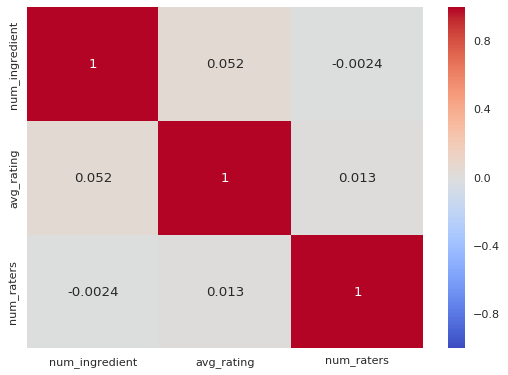

In [48]:
sns.heatmap(num_ingredient_df_corr, annot=True, cmap='coolwarm');

Very low/no correlation.

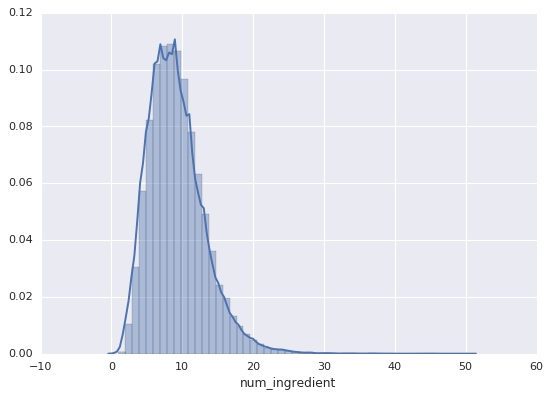

In [18]:
sns.distplot(num_ingredient_df['num_ingredient']);

As can be seen the distribution of the number of ingredients is highly skewed. The mode seems to be around 10 ingredients. It will be interesting to see the relationship between the average review and the number of ingredients (maybe people like recipes with less ingredients?)

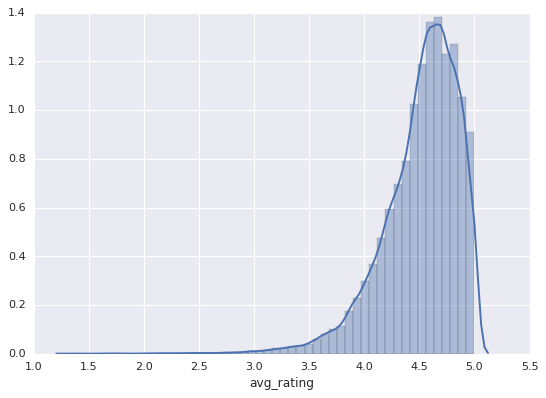

In [97]:
sns.distplot(num_ingredient_df['avg_rating']);

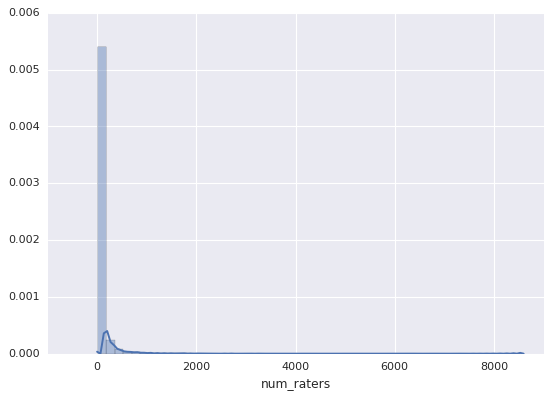

In [99]:
sns.distplot(num_ingredient_df['num_raters']);

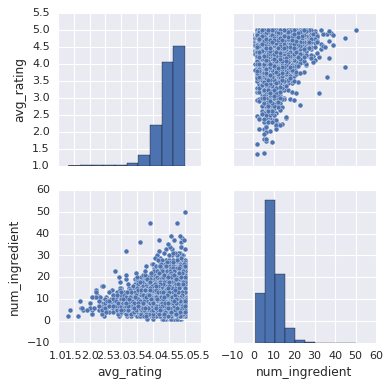

In [19]:
sns.pairplot(num_ingredient_df[['avg_rating','num_ingredient']],  palette="husl");

There is certainly seems to be a relationship but it seems that recipes with more ingredients tend to have higher average ratings with lower variability. Lets look what is the recipe with the highest num_ingredients.

In [20]:
num_ingredient_df.sort_values('num_ingredient', ascending=False).iloc[1]['url']

'http://www.food.com/recipe/real-fajitas-a-dissertation-on-fajitas-222092'

Let's look at this recipe images

In [21]:
%%sql 
SELECT url, images
FROM [wellio-kadaif:recipes.recipes]
Where url == 'http://www.food.com/recipe/sweet-kolache-recipe-39387'

url,images
http://www.food.com/recipe/sweet-kolache-recipe-39387,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/39/38/7/picFrSHJJ.jpg"


In [48]:
Image(url='http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/39/38/7/picFrSHJJ.jpg')

This looks like a relative easy recipe so why does it have so many ingredients? Lets look at the ingredients

In [23]:
%%sql 
SELECT url, ingredients
FROM [wellio-kadaif:recipes.recipes]
Where url == 'http://www.food.com/recipe/sweet-kolache-recipe-39387'

url,ingredients
http://www.food.com/recipe/sweet-kolache-recipe-39387,For Dough
http://www.food.com/recipe/sweet-kolache-recipe-39387,3 packages dry yeast
http://www.food.com/recipe/sweet-kolache-recipe-39387,1⁄2 cup water
http://www.food.com/recipe/sweet-kolache-recipe-39387,1 teaspoon sugar
http://www.food.com/recipe/sweet-kolache-recipe-39387,1 cup butter
http://www.food.com/recipe/sweet-kolache-recipe-39387,3⁄4 cup sugar
http://www.food.com/recipe/sweet-kolache-recipe-39387,3 egg yolks
http://www.food.com/recipe/sweet-kolache-recipe-39387,2 3⁄4 cups milk (scald and cool to lukewarm)
http://www.food.com/recipe/sweet-kolache-recipe-39387,7 1⁄4 cups flour (more or less)
http://www.food.com/recipe/sweet-kolache-recipe-39387,3 teaspoons salt


This seems like a recipe with different fillings and they are all listed

Let's do the same with average ratings

In [100]:
num_ingredient_df.sort_values('avg_rating', ascending=False).iloc[1]['url']

'http://www.food.com/recipe/special-occasion-dog-bones-biscuits-130117'

In [101]:
%%sql 
SELECT url, images
FROM [wellio-kadaif:recipes.recipes]
Where url == 'http://www.food.com/recipe/special-occasion-dog-bones-biscuits-130117'

url,images
http://www.food.com/recipe/special-occasion-dog-bones-biscuits-130117,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/13/01/17/piclvxyRW.jpg"


In [102]:
Image(url='http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/13/01/17/piclvxyRW.jpg')

Surprise!! Not for humans!!

Repeating with number of raters

In [103]:
num_ingredient_df.sort_values('num_raters', ascending=False).iloc[1]['url']

'http://allrecipes.com/recipe/16066/awesome-slow-cooker-pot-roast/'

In [104]:
%%sql 
SELECT url, images
FROM [wellio-kadaif:recipes.recipes]
Where url == 'http://allrecipes.com/recipe/16066/awesome-slow-cooker-pot-roast/'

url,images
http://allrecipes.com/recipe/16066/awesome-slow-cooker-pot-roast/,http://images.media-allrecipes.com/userphotos/250x250/00/14/22/142248.jpg
http://allrecipes.com/recipe/16066/awesome-slow-cooker-pot-roast/,http://images.media-allrecipes.com/userphotos/250x250/00/16/19/161918.jpg
http://allrecipes.com/recipe/16066/awesome-slow-cooker-pot-roast/,http://images.media-allrecipes.com/userphotos/250x250/00/00/49/4997.jpg
http://allrecipes.com/recipe/16066/awesome-slow-cooker-pot-roast/,http://images.media-allrecipes.com/userphotos/250x250/00/10/18/101864.jpg
http://allrecipes.com/recipe/16066/awesome-slow-cooker-pot-roast/,http://images.media-allrecipes.com/userphotos/250x250/03/24/68/3246818.jpg
http://allrecipes.com/recipe/16066/awesome-slow-cooker-pot-roast/,http://images.media-allrecipes.com/userphotos/250x250/00/00/45/4506.jpg
http://allrecipes.com/recipe/16066/awesome-slow-cooker-pot-roast/,http://images.media-allrecipes.com/userphotos/250x250/00/06/66/66663.jpg
http://allrecipes.com/recipe/16066/awesome-slow-cooker-pot-roast/,http://images.media-allrecipes.com/userphotos/250x250/00/02/86/28613.jpg
http://allrecipes.com/recipe/16066/awesome-slow-cooker-pot-roast/,http://images.media-allrecipes.com/userphotos/250x250/00/22/56/225627.jpg
http://allrecipes.com/recipe/16066/awesome-slow-cooker-pot-roast/,http://images.media-allrecipes.com/userphotos/250x250/00/18/06/180688.jpg


In [105]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/00/14/22/142248.jpg')

In [106]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/00/16/19/161918.jpg')

In [107]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/00/00/49/4997.jpg')

#### Getting recipes sorted by lowest rating

First, we obtain data that has images

In [117]:
%%sql  --module images_not_null_data
SELECT url, images, avg(rating) AS avg_rating, avg(ratings) AS num_raters
FROM [wellio-kadaif:recipes.recipes]
WHERE images IS NOT NULL
GROUP BY url, images
HAVING  num_raters > 10 AND avg_rating > 0
ORDER BY avg_rating ASC

In [118]:
%%bigquery execute -q images_not_null_data

url,images,avg_rating,num_raters
http://allrecipes.com/recipe/237873/quick-zucchini-chips/,http://images.media-allrecipes.com/userphotos/250x250/01/99/09/1990905.jpg,1.375,13.0
http://allrecipes.com/recipe/237873/quick-zucchini-chips/,http://images.media-allrecipes.com/userphotos/720x405/1990905.jpg,1.375,13.0
http://allrecipes.com/recipe/237873/quick-zucchini-chips/,http://images.media-allrecipes.com/userphotos/250x250/01/18/68/1186890.jpg,1.375,13.0
http://allrecipes.com/recipe/20426/basic-bloody-mary/,http://images.media-allrecipes.com/userphotos/720x405/3209786.jpg,1.64705884457,13.0
http://allrecipes.com/recipe/20426/basic-bloody-mary/,http://images.media-allrecipes.com/userphotos/250x250/03/20/97/3209786.jpg,1.64705884457,13.0
http://allrecipes.com/recipe/87993/italian-cheese-balls/,http://images.media-allrecipes.com/userphotos/250x250/793032.jpg,1.6875,15.0
http://allrecipes.com/recipe/241161/coconut-flour-pancake/,http://images.media-allrecipes.com/userphotos/720x405/2243266.jpg,1.72727274895,11.0
http://allrecipes.com/recipe/241161/coconut-flour-pancake/,http://images.media-allrecipes.com/userphotos/250x250/02/24/32/2243266.jpg,1.72727274895,11.0
http://allrecipes.com/recipe/9523/vegan-peanut-butter-fudge/,http://images.media-allrecipes.com/userphotos/250x250/01/46/22/1462267.jpg,1.76923072338,11.0
http://allrecipes.com/recipe/9523/vegan-peanut-butter-fudge/,http://images.media-allrecipes.com/userphotos/720x405/1462267.jpg,1.76923072338,11.0


In [119]:
images_df = bq.Query(images_not_null_data).to_dataframe()

In [121]:
images_df.head()

,url,images,avg_rating,num_raters
0,http://allrecipes.com/recipe/237873/quick-zucchini-chips/,http://images.media-allrecipes.com/userphotos/250x250/01/99/09/1990905.jpg,1.375000,13.0
1,http://allrecipes.com/recipe/237873/quick-zucchini-chips/,http://images.media-allrecipes.com/userphotos/720x405/1990905.jpg,1.375000,13.0
2,http://allrecipes.com/recipe/237873/quick-zucchini-chips/,http://images.media-allrecipes.com/userphotos/250x250/01/18/68/1186890.jpg,1.375000,13.0
3,http://allrecipes.com/recipe/20426/basic-bloody-mary/,http://images.media-allrecipes.com/userphotos/720x405/3209786.jpg,1.647059,13.0
4,http://allrecipes.com/recipe/20426/basic-bloody-mary/,http://images.media-allrecipes.com/userphotos/250x250/03/20/97/3209786.jpg,1.647059,13.0


In [124]:
Image(url='http://images.media-allrecipes.com/userphotos/720x405/3209786.jpg')

Pretty ugly image of a bloody mary.

In [69]:
%%sql
SELECT url, images, avg(rating) AS avg_rating, avg(ratings) AS num_raters
FROM [wellio-kadaif:recipes.recipes]
WHERE images IS NOT NULL
GROUP BY url, images
HAVING  num_raters > 10 AND avg_rating > 0
ORDER BY avg_rating DESC

url,images,avg_rating,num_raters
http://www.food.com/recipe/chocolate-fudge-cupcakes-22427,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/22/42/7/picb0InBu.jpg",5.0,11.0
http://www.food.com/recipe/mickies-197960,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/19/79/60/picwuEBhO.jpg",5.0,11.0
http://www.food.com/recipe/blueberry-banana-pie-29234,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/29/23/4/picvYHRN1.jpg",5.0,11.0
http://www.food.com/recipe/guacamole-barefoot-contessa-ina-garten-173063,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/17/30/63/picRV4ePC.jpg",5.0,13.0
http://www.food.com/recipe/types-of-sushi-rolls-261412,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/26/14/12/picfkNlWv.jpg",5.0,17.0
http://www.food.com/recipe/swiss-enchiladas-enchiladas-suizas-88413,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/88/41/3/piccQKjcO.jpg",5.0,21.0
http://www.food.com/recipe/deep-dark-chocolate-moist-cake-94493,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/94/49/3/picAbRMFK.jpg",5.0,11.0
http://www.food.com/recipe/moroccan-fruit-salad-262172,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/26/21/72/pic2y6H70.jpg",5.0,13.0
http://www.food.com/recipe/moroccan-fruit-salad-262172,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/26/21/72/picYcZzRg.jpg",5.0,13.0
http://allrecipes.com/recipe/237196/whole-wheat-coconut-oil-waffles/,http://images.media-allrecipes.com/userphotos/250x250/02/18/66/2186648.jpg,5.0,15.0


In [70]:
Image(url='http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/22/42/7/picb0InBu.jpg')

In [71]:
Image(url='http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/19/79/60/picwuEBhO.jpg')

In [94]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/01/92/08/1920874.jpg')

In [95]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/02/18/66/2186648.jpg')

Are 250x250 images better? It seems so.

#### Another approach, which has not filtered out absent images
We sort the initial dataframe by average ratings in ascending order.

In [57]:
num_ingredient_sorted_df = num_ingredient_df.sort_values(by=['avg_rating'], ascending=True)

In [58]:
num_ingredient_sorted_df.head()

,url,num_ingredient,avg_rating,num_raters
12564,http://www.food.com/recipe/sushi-144236,2,1.330000,13.0
32020,http://allrecipes.com/recipe/237873/quick-zucchini-chips/,5,1.375000,13.0
31561,http://allrecipes.com/recipe/20426/basic-bloody-mary/,2,1.647059,13.0
3503,http://allrecipes.com/recipe/87993/italian-cheese-balls/,9,1.687500,15.0
10428,http://allrecipes.com/recipe/241161/coconut-flour-pancake/,6,1.727273,11.0


In [59]:
num_ingredient_sorted_df.url.head()

12564    http://www.food.com/recipe/sushi-144236                   
32020    http://allrecipes.com/recipe/237873/quick-zucchini-chips/ 
31561    http://allrecipes.com/recipe/20426/basic-bloody-mary/     
3503     http://allrecipes.com/recipe/87993/italian-cheese-balls/  
10428    http://allrecipes.com/recipe/241161/coconut-flour-pancake/
Name: url, dtype: object

Let's look at images of recipes with low reviews:

In [53]:
%%sql 
SELECT images
FROM [wellio-kadaif:recipes.recipes]
WHERE url == 'http://www.food.com/recipe/sushi-144236'

images
""


The above one has no image.

Let's look at another example.

In [50]:
%%sql 
SELECT images
FROM [wellio-kadaif:recipes.recipes]
WHERE url == 'http://allrecipes.com/recipe/237873/quick-zucchini-chips/'

images
http://images.media-allrecipes.com/userphotos/250x250/01/99/09/1990905.jpg
http://images.media-allrecipes.com/userphotos/250x250/01/18/68/1186890.jpg
http://images.media-allrecipes.com/userphotos/720x405/1990905.jpg


In [49]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/01/99/09/1990905.jpg')

In [51]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/01/18/68/1186890.jpg')

In [52]:
Image(url='http://images.media-allrecipes.com/userphotos/720x405/1990905.jpg')

The images are pretty bad!!

### EDA of Social Media scores

How many records?

In [29]:
%%sql 
SELECT count(*) as num_rows
FROM [wellio-kadaif:recipes.social_media] 

num_rows
1181236


How many records don't have social media source?

In [31]:
%%sql 
SELECT count(*) as num_rows
FROM [wellio-kadaif:recipes.social_media]
WHERE social_media IS NULL

num_rows
201422


Count of records per social media source.

In [30]:
%%sql 
SELECT social_media, count(social_media) as count
FROM [wellio-kadaif:recipes.social_media]
GROUP BY social_media
HAVING count > 0

social_media,count
FB,488128
Pinterest,491686


How many url's?

In [8]:
%%sql 
SELECT count(url) as count
FROM [wellio-kadaif:recipes.social_media]
WHERE social_media IS NOT NULL

count
979814


How many unique url's?

In [7]:
%%sql 
SELECT count(DISTINCT(url)) as count
FROM [wellio-kadaif:recipes.social_media]
WHERE social_media IS NOT NULL

count
104778


What's the average score per social media?

In [2]:
%%sql 
SELECT social_media, avg(score) as avg_score
FROM [wellio-kadaif:recipes.social_media]
GROUP BY social_media
HAVING avg_score > 0

social_media,avg_score
FB,397.64414252
Pinterest,23856.9258368


Do we have duplicated url's per social media?

In [15]:
%%sql 
SELECT social_media, url, count(*) as record_count
FROM [wellio-kadaif:recipes.social_media]
WHERE social_media IS NOT NULL
GROUP BY url, social_media

social_media,url,record_count
FB,http://www.food.com/recipe/blueberry-buckle-13453,3
FB,http://www.food.com/recipe/chocolate-peanut-butter-cookies-335901,3
FB,http://www.food.com/recipe/family-favorite-pot-roast-289343,4
FB,http://www.food.com/recipe/guy-fieris-turkey-chicken-patty-burgers-375744,3
FB,http://www.food.com/recipe/mahi-mahi-with-a-pear-and-jalapeno-chutney-417142,3
FB,http://www.food.com/recipe/sea-shell-salad-with-mayo-90803,3
FB,http://www.food.com/recipe/black-and-blue-apple-crisp-with-orange-almond-sauce-354663,3
FB,http://www.food.com/recipe/fresh-cherry-cobbler-492140,4
FB,http://www.food.com/recipe/white-beans-with-lemon-and-dill-94965,3
FB,http://www.food.com/recipe/hungarian-szekely-goulash-273010,3


Yes, we have duplicates, like:

In [14]:
%%sql
SELECT *
FROM [wellio-kadaif:recipes.social_media]
where url = 'http://www.food.com/recipe/blueberry-buckle-13453'

social_media,score,url,item_id,item_kind,payload
FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,8624be1b179a9d9b5a49f1bda6c58075,recipe,"{""id"": ""http://www.food.com/recipe/blueberry-buckle-13453"", ""share"": {""share_count"": 40, ""comment_count"": 0}, ""og_object"": {""description"": ""This is kind of like a blueberry coffee cake. Very good with fresh blueberries. A summertime favorite with my family."", ""id"": ""10150276760181590"", ""updated_time"": ""2015-06-11T03:43:28+0000"", ""type"": ""website"", ""title"": ""Blueberry Buckle Recipe - Food.com""}}"
FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,8624be1b179a9d9b5a49f1bda6c58075,recipe,"{""id"": ""http://www.food.com/recipe/blueberry-buckle-13453"", ""share"": {""share_count"": 40, ""comment_count"": 0}, ""og_object"": {""description"": ""This is kind of like a blueberry coffee cake. Very good with fresh blueberries. A summertime favorite with my family."", ""id"": ""10150276760181590"", ""updated_time"": ""2015-06-11T03:43:28+0000"", ""type"": ""website"", ""title"": ""Blueberry Buckle Recipe - Food.com""}}"
FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,8624be1b179a9d9b5a49f1bda6c58075,recipe,"{""id"": ""http://www.food.com/recipe/blueberry-buckle-13453"", ""share"": {""share_count"": 40, ""comment_count"": 0}, ""og_object"": {""description"": ""This is kind of like a blueberry coffee cake. Very good with fresh blueberries. A summertime favorite with my family."", ""id"": ""10150276760181590"", ""updated_time"": ""2015-06-11T03:43:28+0000"", ""type"": ""website"", ""title"": ""Blueberry Buckle Recipe - Food.com""}}"
Pinterest,208.0,http://www.food.com/recipe/blueberry-buckle-13453,8624be1b179a9d9b5a49f1bda6c58075,recipe,"{""count"": 208, ""url"": ""http://www.food.com/recipe/blueberry-buckle-13453""}"
Pinterest,208.0,http://www.food.com/recipe/blueberry-buckle-13453,8624be1b179a9d9b5a49f1bda6c58075,recipe,"{""count"": 208, ""url"": ""http://www.food.com/recipe/blueberry-buckle-13453""}"
Pinterest,208.0,http://www.food.com/recipe/blueberry-buckle-13453,8624be1b179a9d9b5a49f1bda6c58075,recipe,"{""count"": 208, ""url"": ""http://www.food.com/recipe/blueberry-buckle-13453""}"


How many item_kind we have?

In [6]:
%%sql 
SELECT item_kind, count(item_kind) as count
FROM [wellio-kadaif:recipes.social_media]
GROUP BY item_kind
HAVING count > 0

item_kind,count
recipe,1181236


In [20]:
%%sql
SELECT social_media, score, url
FROM [wellio-kadaif:recipes.social_media]
WHERE social_media IS NOT NULL
GROUP BY url, social_media, score

social_media,score,url
FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453
FB,22.0,http://www.food.com/recipe/chocolate-peanut-butter-cookies-335901
FB,0.0,http://www.food.com/recipe/family-favorite-pot-roast-289343
FB,2.0,http://www.food.com/recipe/guy-fieris-turkey-chicken-patty-burgers-375744
FB,0.0,http://www.food.com/recipe/mahi-mahi-with-a-pear-and-jalapeno-chutney-417142
FB,0.0,http://www.food.com/recipe/sea-shell-salad-with-mayo-90803
FB,0.0,http://www.food.com/recipe/black-and-blue-apple-crisp-with-orange-almond-sauce-354663
FB,0.0,http://www.food.com/recipe/fresh-cherry-cobbler-492140
FB,2.0,http://www.food.com/recipe/white-beans-with-lemon-and-dill-94965
FB,26.0,http://www.food.com/recipe/hungarian-szekely-goulash-273010


In [21]:
%%sql --module social_media_data
SELECT social_media, score, url
FROM [wellio-kadaif:recipes.social_media]
WHERE social_media IS NOT NULL

In [22]:
%%bigquery execute -q social_media_data

social_media,score,url
FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453
FB,22.0,http://www.food.com/recipe/chocolate-peanut-butter-cookies-335901
FB,0.0,http://www.food.com/recipe/family-favorite-pot-roast-289343
FB,2.0,http://www.food.com/recipe/guy-fieris-turkey-chicken-patty-burgers-375744
FB,0.0,http://www.food.com/recipe/mahi-mahi-with-a-pear-and-jalapeno-chutney-417142
FB,0.0,http://www.food.com/recipe/sea-shell-salad-with-mayo-90803
FB,0.0,http://www.food.com/recipe/black-and-blue-apple-crisp-with-orange-almond-sauce-354663
FB,0.0,http://www.food.com/recipe/fresh-cherry-cobbler-492140
FB,2.0,http://www.food.com/recipe/white-beans-with-lemon-and-dill-94965
FB,26.0,http://www.food.com/recipe/hungarian-szekely-goulash-273010


#### How to sample:
http://localhost:8081/notebooks/datalab/docs/tutorials/BigQuery/BigQuery%20Magic%20Commands%20and%20DML.ipynb 

In [65]:
%%bq query --name SocialMedia
WITH SocialMedia AS
(SELECT social_media, score, url
FROM `wellio-kadaif.recipes.social_media`
WHERE social_media IS NOT NULL)
SELECT * FROM SocialMedia LIMIT 10

In [66]:
%%bq dryrun -q SocialMedia

In [67]:
%%bq sample -q SocialMedia

social_media,score,url
FB,0.0,http://www.food.com/recipe/family-favorite-pot-roast-289343
FB,0.0,http://www.food.com/recipe/black-and-blue-apple-crisp-with-orange-almond-sauce-354663
FB,0.0,http://www.food.com/recipe/mahi-mahi-with-a-pear-and-jalapeno-chutney-417142
FB,0.0,http://www.food.com/recipe/fresh-cherry-cobbler-492140
FB,0.0,http://www.food.com/recipe/sea-shell-salad-with-mayo-90803
FB,2.0,http://www.food.com/recipe/white-beans-with-lemon-and-dill-94965
FB,2.0,http://www.food.com/recipe/guy-fieris-turkey-chicken-patty-burgers-375744
FB,22.0,http://www.food.com/recipe/chocolate-peanut-butter-cookies-335901
FB,26.0,http://www.food.com/recipe/hungarian-szekely-goulash-273010
FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453


### Merging recipe images with social media score

We join both datasets using url as key.

In [132]:
%%sql
SELECT s.social_media, s.score, s.url
FROM [wellio-kadaif:recipes.social_media] AS s
INNER JOIN [wellio-kadaif:recipes.recipes] AS r ON s.url = r.url
WHERE s.social_media IS NOT NULL AND r.images IS NOT NULL

s_social_media,s_score,s_url
FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453
FB,22.0,http://www.food.com/recipe/chocolate-peanut-butter-cookies-335901
FB,0.0,http://www.food.com/recipe/mahi-mahi-with-a-pear-and-jalapeno-chutney-417142
FB,26.0,http://www.food.com/recipe/hungarian-szekely-goulash-273010
FB,17.0,http://allrecipes.com/recipe/12152/my-grandmothers-best-berry-pie/
FB,1.0,http://www.food.com/recipe/grecian-skillet-rib-eyes-427985
FB,17.0,http://www.food.com/recipe/cranberry-apple-jam-469440
FB,0.0,http://www.food.com/recipe/savory-low-fat-cinnamon-loaf-116125
FB,134.0,http://www.food.com/recipe/bohemian-sweet-and-sour-cabbage-169164
FB,13.0,http://www.food.com/recipe/best-ever-alfredo-sauce-414533


In [73]:
%%sql
SELECT s.social_media, s.score, s.url, r.images, avg(r.rating) AS avg_rating, avg(r.ratings) AS num_raters
FROM [wellio-kadaif:recipes.social_media] AS s
INNER JOIN [wellio-kadaif:recipes.recipes] AS r ON s.url = r.url
WHERE s.social_media IS NOT NULL AND r.images IS NOT NULL
GROUP BY s.social_media, s.score, s.url, r.images
ORDER BY avg_rating DESC

s_social_media,s_score,s_url,r_images,avg_rating,num_raters
FB,5.0,http://www.food.com/recipe/crispy-chicken-schnitzel-53060,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/53/06/0/piclbFYZv.jpg",5.0,3.0
FB,7.0,http://www.food.com/recipe/diabetic-oatmeal-cookies-with-chocolate-chunks-and-candied-ginge-457736,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/45/77/36/pic5NjatG.jpg",5.0,1.0
FB,48.0,http://allrecipes.com/recipe/234491/pear-pie/,http://images.media-allrecipes.com/userphotos/720x405/3925199.jpg,5.0,7.0
FB,385.0,http://www.food.com/recipe/texas-chewy-pralines-105889,http://pictures.food.com/api/file/jsbr4GLvRwGd7jbZMrXb-Texas-Chewy-Pralines.jpg/convert?loc=/pictures.food.com/recipes/10/58/89/nobnFliBTdacw2JLqSwx_Texas%20Chewy%20Pralines.jpg&width=614&height=461&fit=crop,5.0,5.0
FB,41.0,http://www.food.com/recipe/roy-rogers-crispy-fried-chicken-copycat-123826,http://pictures.food.com/api/file/Jr31KkrvRwGqFbKeNSpX-DSCN0787.JPG/convert?loc=/pictures.food.com/recipes/12/38/26/KZysqkXgT0SeCK8HUWtB_DSCN0787.JPG&width=614&height=461&fit=crop,5.0,4.0
FB,5.0,http://www.food.com/recipe/macaroni-cheese-pizza-285492,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/28/54/92/picU4JVIp.jpg",5.0,1.0
FB,0.0,http://www.food.com/recipe/cheesy-lemon-butter-128517,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/12/85/17/picrcHo0o.jpg",5.0,4.0
Pinterest,139.0,http://www.food.com/recipe/american-style-vanilla-biscotti-345763,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/34/57/63/pic4QYlMQ.jpg",5.0,6.0
FB,5.0,http://www.food.com/recipe/crispy-chicken-schnitzel-53060,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/53/06/0/picy3cqOo.jpg",5.0,3.0
FB,0.0,http://www.food.com/recipe/macadamia-shortbread-370526,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/37/05/26/picGDVsLA.jpg",5.0,3.0


#### Top images when they are sorted by average review score:

In [74]:
Image(url='http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/53/06/0/piclbFYZv.jpg')

In [75]:
Image(url='http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/45/77/36/pic5NjatG.jpg')

In [84]:
%%sql
SELECT s.social_media, s.score, s.url, r.images, avg(r.rating) AS avg_rating, avg(r.ratings) AS num_raters
FROM [wellio-kadaif:recipes.social_media] AS s
INNER JOIN [wellio-kadaif:recipes.recipes] AS r ON s.url = r.url
WHERE s.social_media IS NOT NULL AND r.images IS NOT NULL
GROUP BY s.social_media, s.score, s.url, r.images
ORDER BY s.score DESC

s_social_media,s_score,s_url,r_images,avg_rating,num_raters
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/60/35/603558.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/01/11/96/1119606.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/90/49/904982.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/79/95/799522.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/01/11/71/1117105.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/02/61/59/2615969.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/12/68/126862.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/01/05/63/1056379.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/60/23/602351.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/05/81/58132.jpg,4.09134626389,160.0


#### Top images sorted by social media score descending:

In [85]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/00/60/35/603558.jpg')

In [86]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/01/11/96/1119606.jpg')

In [2]:
%%sql --module edamame_data
SELECT s.social_media, s.score, s.url, r.images, avg(r.rating) AS avg_rating, avg(r.ratings) AS num_raters
FROM [wellio-kadaif:recipes.social_media] AS s
INNER JOIN [wellio-kadaif:recipes.recipes] AS r ON s.url = r.url
WHERE s.social_media IS NOT NULL AND r.images IS NOT NULL AND s.url = 'http://allrecipes.com/recipe/150772/crispy-edamame/'
GROUP BY s.social_media, s.score, s.url, r.images

In [3]:
%%bigquery execute -q edamame_data

s_social_media,s_score,s_url,r_images,avg_rating,num_raters
FB,668.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/27/75/277540.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/01/11/96/1119606.jpg,4.09134626389,160.0
FB,668.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/01/11/03/1110380.jpg,4.09134626389,160.0
FB,668.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/80/93/809344.jpg,4.09134626389,160.0
FB,668.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/01/11/71/1117105.jpg,4.09134626389,160.0
FB,668.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/61/00/610058.jpg,4.09134626389,160.0
FB,668.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/01/05/63/1056379.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/79/95/799522.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/60/82/608294.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/01/09/91/1099189.jpg,4.09134626389,160.0


In [4]:
edamame_df = bq.Query(edamame_data).to_dataframe()

In [5]:
edamame_social_df = pd.DataFrame(edamame_df.groupby(['s_social_media','r_images']).size()).reset_index()
edamame_fb_df = edamame_social_df[edamame_social_df['s_social_media'] == 'FB']
edamame_pt_df = edamame_social_df[edamame_social_df['s_social_media'] == 'Pinterest']

In [6]:
edamame_fb_list = edamame_fb_df['r_images'].tolist()

In [7]:
edamame_pt_list = edamame_pt_df['r_images'].tolist()

#### Edamame pictures from facebook:

In [8]:
# From a list of url's of images, we create a list of images.
edamame_fb_image_list = [Image(url=image) for image in edamame_fb_list]

#### Show images as a 4 by 5 grid (20 images). First for facebook.
Pictures will be downloaded in below folder:

In [13]:
folder_fb = 'images-EDA-fb'

In [14]:
# We proceed to download. Note that we need to str() the url to make it work and we save the name of the image with it's original name using
# .split('/')[-1]
for url in edamame_fb_list:
  urllib.urlretrieve(str(url), folder_fb + '/' + str(url).split('/')[-1])

In [16]:
# Now, we save the images in a list.
fb_image_list = []
for filename in glob.glob(folder_fb + '/*.*'):
    im = img.open(filename)
    fb_image_list.append(im)

In [19]:
fb_image_list = []

In [21]:
# More efficient to use a list comprehension.
fb_image_list = [img.open(filename) for filename in glob.glob(folder_fb + '/*.*')]

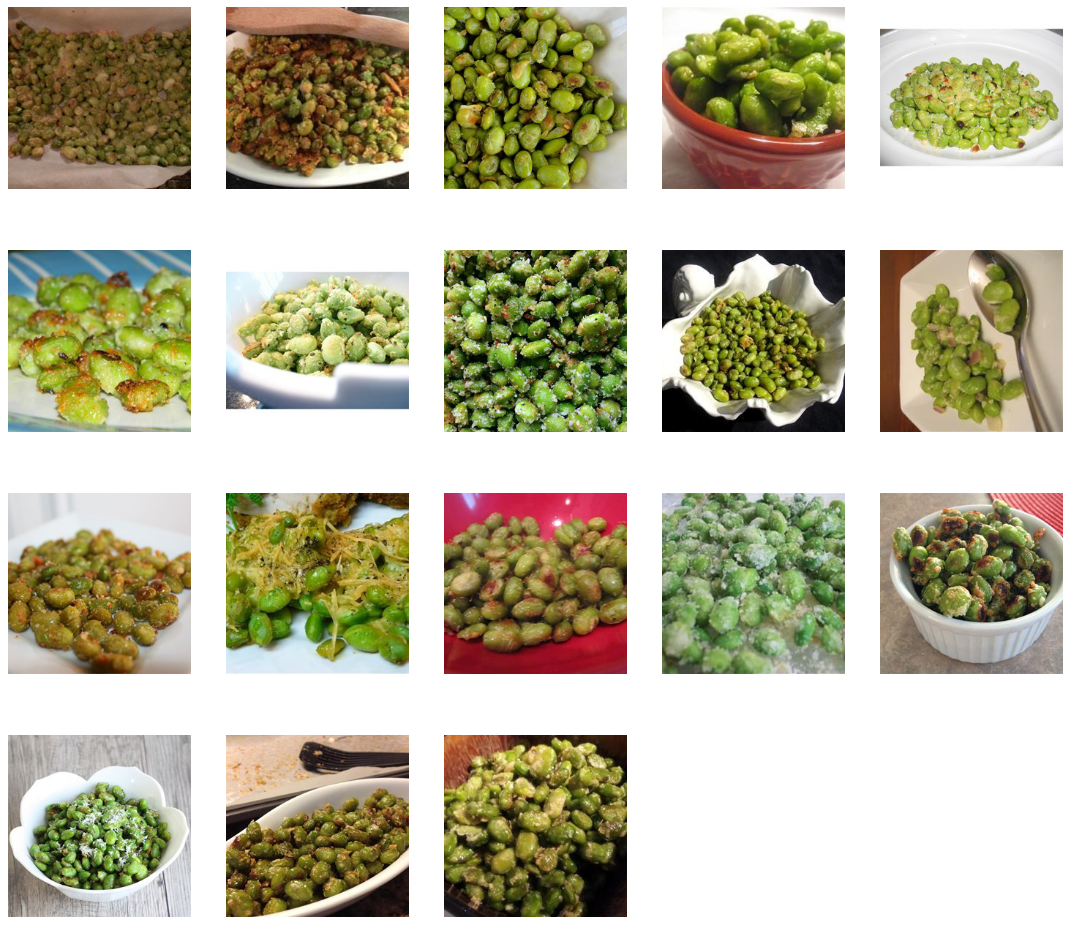

In [22]:
# Showing all images in a grid.
fig = plt.figure(figsize=(17,15))
for i in range(1, len(fb_image_list)):
    fig.add_subplot(4, 5, i)
    # In order to display the image with index 0, we substract 1 to i (remember, we started at 1).
    plt.imshow(fb_image_list[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

plt.show();

#### Similar to above, but for Pinterest.

In [23]:
folder_pt = 'images-EDA-pt'

In [24]:
for url in edamame_pt_list:
  urllib.urlretrieve(str(url), folder_pt + '/' + str(url).split('/')[-1])

In [198]:
pt_image_list = []
for filename in glob.glob(folder_pt + '/*.*'):
    im = img.open(filename)
    pt_image_list.append(im)

In [25]:
pt_image_list = []

In [26]:
# More efficient to use a list comprehension.
pt_image_list = [img.open(filename) for filename in glob.glob(folder_pt + '/*.*')]

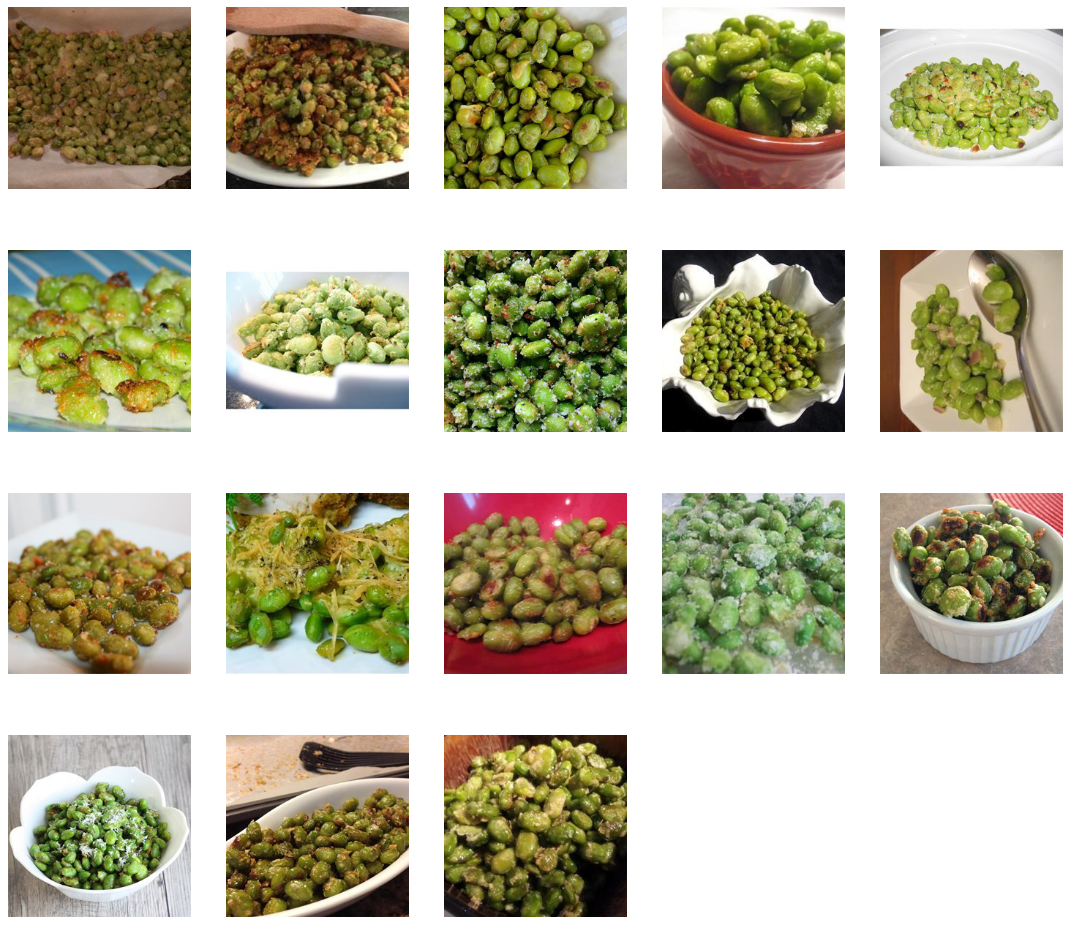

In [27]:
fig = plt.figure(figsize=(17,15))
for i in range(1, len(pt_image_list)):
    fig.add_subplot(4, 5, i)
    # In order to display the image with index 0, we substract 1 to i (remember, we started at 1).
    plt.imshow(pt_image_list[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

plt.show();

Below we print images one by one.

In [123]:
for image in edamame_fb_list:
  s = image.split(".com/")
  print("Image source: " + s[0] + ".com")
  display(Image(url=image))

Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


#### Edamame pictures from Pinterest:

In [124]:
for image in edamame_pt_list:
  s = image.split(".com/")
  print("Image source: " + s[0] + ".com")
  display(Image(url=image))

Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


Image source: http://images.media-allrecipes.com


In [78]:
%%sql
SELECT s.social_media, s.score, s.url, r.images, avg(r.rating) AS avg_rating, avg(r.ratings) AS num_raters
FROM [wellio-kadaif:recipes.social_media] AS s
INNER JOIN [wellio-kadaif:recipes.recipes] AS r ON s.url = r.url
WHERE s.social_media IS NOT NULL AND r.images IS NOT NULL
GROUP BY s.social_media, s.score, s.url, r.images
ORDER BY s.score DESC, avg_rating DESC

s_social_media,s_score,s_url,r_images,avg_rating,num_raters
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/01/05/63/1056379.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/02/61/59/2615969.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/80/93/809344.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/01/11/96/1119606.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/58132.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/90/49/904982.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/60/23/602351.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/61/00/610058.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/60/82/608292.jpg,4.09134626389,160.0
Pinterest,988093.0,http://allrecipes.com/recipe/150772/crispy-edamame/,http://images.media-allrecipes.com/userphotos/250x250/00/05/81/58132.jpg,4.09134626389,160.0


#### Top images sorted by social media score first, then recipe score, both descending:

In [79]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/01/05/63/1056379.jpg')

In [81]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/02/61/59/2615969.jpg')

In [4]:
%%sql --module merge_social_score_image_data
SELECT s.social_media, s.score, s.url, r.images
FROM [wellio-kadaif:recipes.social_media] AS s
INNER JOIN [wellio-kadaif:recipes.recipes] AS r ON s.url = r.url
WHERE s.social_media IS NOT NULL AND r.images IS NOT NULL

In [5]:
%%bigquery execute -q merge_social_score_image_data

s_social_media,s_score,s_url,r_images
FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/13/45/3/picyyFOOy.jpg"
FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/13/45/3/ZcJFqjs1SqyNUe8Mfjhw_FullSizeRender.jpg"
FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/13/45/3/picE8Qx0w.jpg"
FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/13/45/3/picSiLcgm.jpg"
FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/13/45/3/picA6LaKS.jpg"
FB,22.0,http://www.food.com/recipe/chocolate-peanut-butter-cookies-335901,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/33/59/01/picVbf7eK.jpg"
FB,22.0,http://www.food.com/recipe/chocolate-peanut-butter-cookies-335901,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/33/59/01/picspPRfg.jpg"
FB,0.0,http://www.food.com/recipe/mahi-mahi-with-a-pear-and-jalapeno-chutney-417142,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/41/71/42/picitqzTm.jpg"
FB,26.0,http://www.food.com/recipe/hungarian-szekely-goulash-273010,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/27/30/10/pic9c7XYv.jpg"
FB,26.0,http://www.food.com/recipe/hungarian-szekely-goulash-273010,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/27/30/10/pictrfhzQ.jpg"


In [6]:
images_social_media_df = bq.Query(merge_social_score_image_data).to_dataframe()

In [7]:
images_social_media_df.head()

,s_social_media,s_score,s_url,r_images
0,FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/13/45/3/picyyFOOy.jpg"
1,FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/13/45/3/ZcJFqjs1SqyNUe8Mfjhw_FullSizeRender.jpg"
2,FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/13/45/3/picE8Qx0w.jpg"
3,FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/13/45/3/picSiLcgm.jpg"
4,FB,40.0,http://www.food.com/recipe/blueberry-buckle-13453,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/13/45/3/picA6LaKS.jpg"


In [43]:
images_social_media_df.groupby('s_social_media').describe()

s_score
s_social_media                     
FB             count  279463.000000
               mean   1571.970615  
               std    19847.600351 
               min    0.000000     
               25%    3.000000     
               50%    34.000000    
               75%    382.000000   
               max    663490.000000
Pinterest      count  285138.000000
               mean   8306.656328  
               std    54508.259551 
               min    0.000000     
               25%    11.000000    
               50%    129.000000   
               75%    2368.000000  
               max    988093.000000

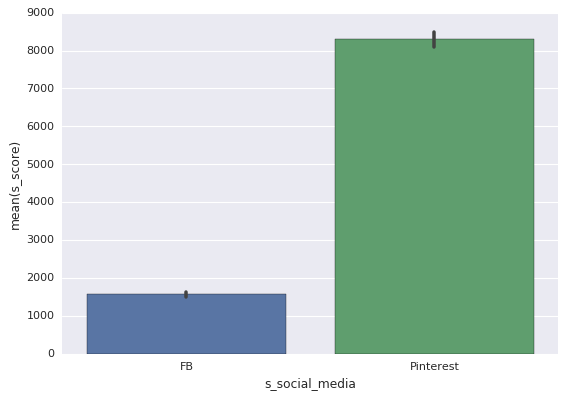

In [23]:
sns.barplot(x='s_social_media', y='s_score', data=images_social_media_df);

In [87]:
%%sql --module rating_social_score_data
SELECT s.social_media, s.score, s.url, r.images, avg(r.rating) AS avg_rating, avg(r.ratings) AS num_raters
FROM [wellio-kadaif:recipes.social_media] AS s
INNER JOIN [wellio-kadaif:recipes.recipes] AS r ON s.url = r.url
WHERE s.social_media IS NOT NULL AND r.images IS NOT NULL
GROUP BY s.social_media, s.score, s.url, r.images

In [88]:
%%bigquery execute -q rating_social_score_data

s_social_media,s_score,s_url,r_images,avg_rating,num_raters
FB,1.0,http://www.food.com/recipe/sweet-and-spicy-chicken-wings-301648,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/30/16/48/picxRHmNm.jpg",5.0,3.0
FB,1.0,http://www.food.com/recipe/fried-rice-75031,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/75/03/1/picSDz0gg.jpg",4.67,3.0
FB,16.0,http://www.food.com/recipe/lebanese-syrian-bazella-409391,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/40/93/91/picHIHDd7.jpg",5.0,1.0
FB,1.0,http://www.food.com/recipe/low-carb-roll-up-110780,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/11/07/80/pic3e4xLt.jpg",5.0,1.0
FB,1.0,http://www.food.com/recipe/french-cr-me-peanut-butter-cookies-362341,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/36/23/41/pic2a1gb9.jpg",5.0,1.0
FB,2.0,http://www.food.com/recipe/grilled-zucchini-casserole-185848,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/18/58/48/picaIEer3.jpg",4.0,1.0
FB,13.0,http://allrecipes.com/recipe/45574/beef-burgundy-style/,http://images.media-allrecipes.com/userphotos/250x250/00/14/23/142365.jpg,4.69736862183,62.0
FB,13.0,http://allrecipes.com/recipe/45574/beef-burgundy-style/,http://images.media-allrecipes.com/userphotos/250x250/00/80/13/801398.jpg,4.69736862183,62.0
FB,64.0,http://allrecipes.com/recipe/80696/cola-onion-pork-chops/,http://images.media-allrecipes.com/userphotos/250x250/00/20/02/200280.jpg,3.87741947174,127.0
FB,2.0,http://www.food.com/recipe/marmalade-cupcakes-95473,"http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/95/47/3/picnQ9FHq.jpg",4.8,5.0


In [89]:
rating_social_score_df = bq.Query(rating_social_score_data).to_dataframe()

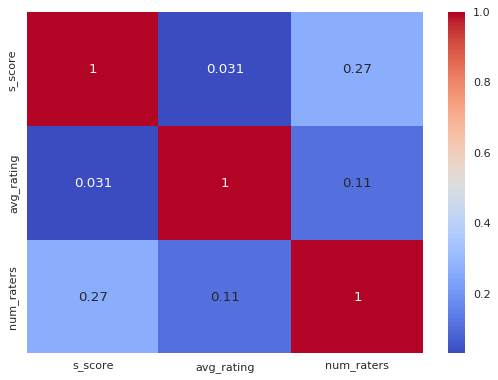

In [90]:
rating_social_score_df_corr = rating_social_score_df[['s_score', 'avg_rating', 'num_raters']].corr()

sns.heatmap(rating_social_score_df_corr, annot=True, cmap='coolwarm');

We can see some positive correlation between the social media score and the number of people providing rating, AND no practically no correlation between social media score and the recipe average rating.

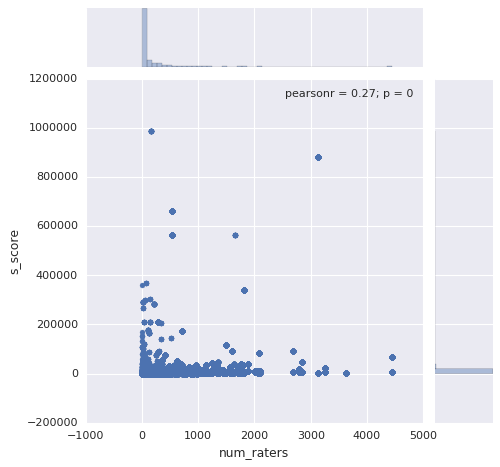

In [92]:
sns.jointplot(x="num_raters", y="s_score", data=rating_social_score_df);

The less number of raters, the higher the social media score.

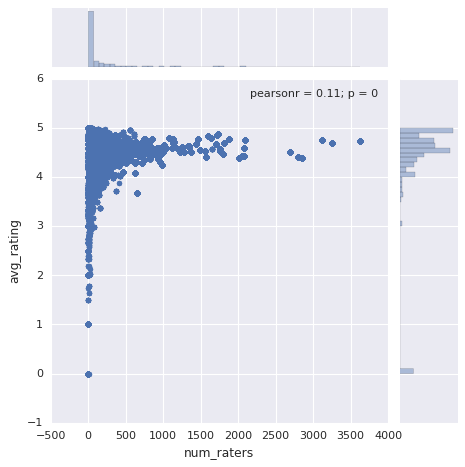

In [96]:
sns.jointplot(x="num_raters", y="avg_rating", data=rating_social_score_df);

The less the number of people rating a recipe, the highest it's rating.

DataFrame only for Facebook:

In [51]:
fb_df = images_social_media_df[images_social_media_df['s_social_media'] == 'FB']

In [52]:
fb_df = fb_df[fb_df['s_score'] > 380]

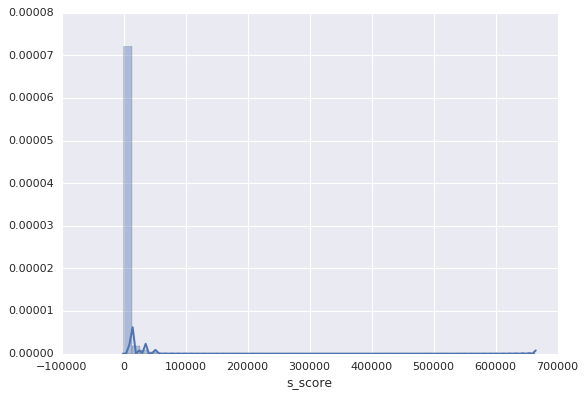

In [53]:
sns.distplot(fb_df['s_score']);

DataFrame only for Pinterest:

In [54]:
pt_df = images_social_media_df[images_social_media_df['s_social_media'] == 'Pinterest']

In [55]:
pt_df = pt_df[pt_df['s_score'] > 2400]

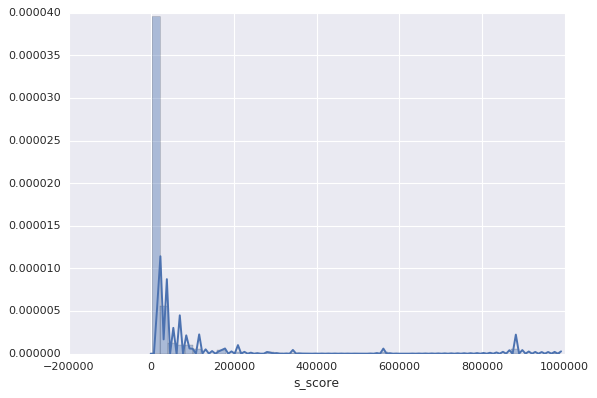

In [56]:
sns.distplot(pt_df['s_score']);

In [59]:
%%sql
SELECT s.social_media, r.images, s.score
FROM [wellio-kadaif:recipes.social_media] AS s
INNER JOIN [wellio-kadaif:recipes.recipes] AS r ON s.url = r.url
WHERE s.social_media IS NOT NULL AND r.images IS NOT NULL AND s.social_media = 'FB' AND s.score > 400
ORDER BY s.score DESC

s_social_media,r_images,s_score
FB,http://images.media-allrecipes.com/userphotos/250x250/03/63/65/3636566.jpg,663490.0
FB,http://images.media-allrecipes.com/userphotos/250x250/03/62/39/3623960.jpg,663490.0
FB,http://images.media-allrecipes.com/userphotos/250x250/01/67/74/1677487.jpg,663490.0
FB,http://images.media-allrecipes.com/userphotos/250x250/03/93/50/3935087.jpg,663490.0
FB,http://images.media-allrecipes.com/userphotos/250x250/00/88/62/886227.jpg,663490.0
FB,http://images.media-allrecipes.com/userphotos/250x250/03/37/80/3378088.jpg,663490.0
FB,http://images.media-allrecipes.com/userphotos/250x250/00/54/03/540375.jpg,663490.0
FB,http://images.media-allrecipes.com/userphotos/250x250/00/89/68/896879.jpg,663490.0
FB,http://images.media-allrecipes.com/userphotos/250x250/03/94/01/3940123.jpg,663490.0
FB,http://images.media-allrecipes.com/userphotos/250x250/03/54/68/3546876.jpg,663490.0


In [62]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/03/63/65/3636566.jpg')

In [61]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/03/62/39/3623960.jpg')

In [67]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/01/67/74/1677487.jpg')

In [63]:
%%sql
SELECT s.social_media, r.images, s.score
FROM [wellio-kadaif:recipes.social_media] AS s
INNER JOIN [wellio-kadaif:recipes.recipes] AS r ON s.url = r.url
WHERE s.social_media IS NOT NULL AND r.images IS NOT NULL AND s.social_media = 'Pinterest' AND s.score > 2400
ORDER BY s.score DESC

s_social_media,r_images,s_score
Pinterest,http://images.media-allrecipes.com/userphotos/250x250/01/09/91/1099189.jpg,988093.0
Pinterest,http://images.media-allrecipes.com/userphotos/250x250/00/05/81/58132.jpg,988093.0
Pinterest,http://images.media-allrecipes.com/userphotos/250x250/01/11/71/1117105.jpg,988093.0
Pinterest,http://images.media-allrecipes.com/userphotos/250x250/00/80/93/809344.jpg,988093.0
Pinterest,http://images.media-allrecipes.com/userphotos/250x250/00/79/95/799522.jpg,988093.0
Pinterest,http://images.media-allrecipes.com/userphotos/250x250/00/12/68/126862.jpg,988093.0
Pinterest,http://images.media-allrecipes.com/userphotos/250x250/00/60/82/608292.jpg,988093.0
Pinterest,http://images.media-allrecipes.com/userphotos/250x250/01/11/96/1119606.jpg,988093.0
Pinterest,http://images.media-allrecipes.com/userphotos/250x250/01/05/63/1056379.jpg,988093.0
Pinterest,http://images.media-allrecipes.com/userphotos/250x250/00/85/78/857893.jpg,988093.0


In [64]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/01/09/91/1099189.jpg')

In [65]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/00/05/81/58132.jpg')

In [66]:
Image(url='http://images.media-allrecipes.com/userphotos/250x250/01/11/71/1117105.jpg')

It seems that the images from Pinterest have better quality compared to Facebook (given a high social score).

### Recipes per website

In [105]:
%%sql --module recipes_sites_data
SELECT substring(url, 1, instr(url, '.com')+4) as domain_url, count(substring(url, 1, instr(url, '.com')+4)) as domain_count
FROM [wellio-kadaif:recipes.social_media]
WHERE url IS NOT NULL
GROUP BY domain_url
ORDER BY domain_count DESC

In [106]:
%%bigquery execute -q recipes_sites_data

domain_url,domain_count
http://www.food.com/,425816
http://www.epicurious.com/,105258
https://www.diabetesselfmanagement.com/,91490
http://juliasalbum.com/,65142
https://iquitsugar.com/,56516
http://allrecipes.com/,44592
http://thepioneerwoman.com/,43370
http://www.feastingathome.com/,42954
http://www.everydayhealth.com/,28440
http://portandfin.com/,26164


In [107]:
recipes_sites_df = bq.Query(recipes_sites_data).to_dataframe()

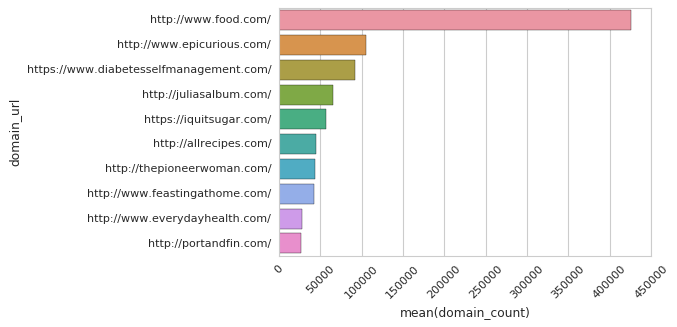

In [144]:
sns.set_style("whitegrid")
recipes_plot = sns.barplot(x='domain_count', y='domain_url', data=recipes_sites_df[:10])
plt.setp(recipes_plot.get_xticklabels(), rotation=45);

Most of the recipes, and therefore images, come from food.com, then epicurious.com

### Getting images with high social score from epicurious

In [155]:
%%sql
SELECT r.url, r.images, s.score
FROM [wellio-kadaif:recipes.recipes] as r
INNER JOIN [wellio-kadaif:recipes.social_media] as s ON r.url = s.url
WHERE substring(r.url, 1, instr(r.url, '.com')+4) = 'http://www.epicurious.com/'
AND images IS NOT NULL AND s.score IS NOT NULL AND s.score > 10000

r_url,r_images,s_score
http://www.epicurious.com/recipes/food/views/roasted-garlic-soup-with-parmesan-cheese-100669,http://assets.epicurious.com/photos/579fa1143a12dd9d5602406d/6:4/w_620%2Ch_413/roasted-garlic-soup-with-parmesan-cheese.jpg,1076.0
http://www.epicurious.com/recipes/food/views/garlic-aioli-roasted-turkey-with-lemon-parsley-au-jus,http://assets.epicurious.com/photos/563117511744353b554e0d61/6:4/w_620%2Ch_413/EP_10132015_Thnksgvng_Menu_turkey.jpg,1474.0
http://www.epicurious.com/recipes/food/views/our-favorite-lasagna-with-sausage-spinach-and-three-cheeses-51253440,http://assets.epicurious.com/photos/5743540d55894b5d6ef74275/6:4/w_620%2Ch_413/51253440_lasagna_6x4-hpr.jpg,2693.0
http://www.epicurious.com/recipes/food/views/quick-sesame-chicken-with-broccoli,http://assets.epicurious.com/photos/56be0c5e3a88332b064ccc90/6:4/w_620%2Ch_413/EP_02112016_22_minute_meals_seasame-chicken.jpg,2121.0
http://www.epicurious.com/recipes/food/views/overnight-egg-cheese-strata-395529,http://assets.epicurious.com/photos/54b17630c6a78d1a4a60c7ba/6:4/w_620%2Ch_413/395529_egg-cheese-strata_1x1.jpg,1129.0
http://www.epicurious.com/recipes/food/views/maple-pecan-sundaes-with-candied-bacon-361274,http://assets.epicurious.com/photos/54b31dfd460b4423363ec8c1/6:4/w_620%2Ch_413/361274_maple-pecan-sundaes_1x1.jpg,1481.0
http://www.epicurious.com/recipes/food/views/bourbon-butterscotch-pudding-51147530,http://assets.epicurious.com/photos/54b03008766062b203448dfd/6:4/w_620%2Ch_413/51147530_bourbon-butterscotch-pudding_1x1.jpg,1486.0
http://www.epicurious.com/recipes/food/views/crispy-black-bean-tacos-with-feta-and-cabbage-slaw-351271,http://assets.epicurious.com/photos/56e30f14c128bff20e48e3ec/6:4/w_620%2Ch_413/351271_hires.jpg,1561.0
http://www.epicurious.com/recipes/food/views/our-favorite-lasagna-with-sausage-spinach-and-three-cheeses-51253440,http://assets.epicurious.com/photos/5743540d55894b5d6ef74275/6:4/w_620%2Ch_413/51253440_lasagna_6x4-hpr.jpg,2703.0
http://www.epicurious.com/recipes/food/views/overnight-egg-cheese-strata-395529,http://assets.epicurious.com/photos/54b17630c6a78d1a4a60c7ba/6:4/w_620%2Ch_413/395529_egg-cheese-strata_1x1.jpg,1129.0


We don't get that many images, less than 1,000.